### Esercitazione - E02 - Autoencoder

Scarica un dataset di immagini reali, costruisci il tuo autoencoder e allenalo per il task di image denoising!

* Usa il dataset [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

* Le immagini di questo dataset in genere hanno shape (3, 32, 32).

* Costruisci un autoencoder basato su reti convoluzionali!

* Per costruire il task di denoising devi avere due versioni delle immagini: una rumorosa che dai in input al modello e una pulita, con cui andrai a calcolare la loss.

⚠️ Puoi utilizzare blocchi di codice che abbiamo scritto nei notebook precedenti!

In [1]:
# Import

import os

import torch # Pytorch
import torchvision # Pytorch per le immagini e il video
from torch import nn
from torch.utils.data import DataLoader # Wrapper per il dataset
from torchvision import transforms # Trasformazioni dei dati
from torchvision.datasets import CIFAR10 # Download del dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [16]:
# Settiamo gli hyperparametri
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [3]:
# Trasformazioni delle immagini

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x


img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((32)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
# Scarichiamo il dataset e inseriamolo nel dataloader
dataset = CIFAR10('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 55518404.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [17]:
# Definiamo la classe dell'Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
# Definiamo un'istanza dell'Autoencoder
model = Autoencoder()
model = model.cuda()

# Definiamo la loss function
criterion = nn.MSELoss()

# Definiamo l'ottimizzatore
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [19]:
if not os.path.exists('/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/ae_img'):
    os.mkdir('/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/ae_img')

# Definiamo il processo di allenamento
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        # Costruiamo l'immagine rumorosa
        noise = torch.randn_like(img)
        noisy_img = img + noise
        # img = img.view(img.size(0), -1)
        noisy_img = noisy_img.cuda()
        img = img.cuda()
        # forward pass
        output = model(noisy_img)
        loss = criterion(output, img)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, '/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/ae_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), '/content/drive/MyDrive/RTD-A/Corsi/2023 - ProfessionAI/Colabs/sim_autoencoder.pth')

epoch [1/100], loss:0.0843
epoch [2/100], loss:0.0569
epoch [3/100], loss:0.0466
epoch [4/100], loss:0.0526
epoch [5/100], loss:0.0516
epoch [6/100], loss:0.0489
epoch [7/100], loss:0.0515
epoch [8/100], loss:0.0497
epoch [9/100], loss:0.0468
epoch [10/100], loss:0.0431
epoch [11/100], loss:0.0399
epoch [12/100], loss:0.0399
epoch [13/100], loss:0.0401
epoch [14/100], loss:0.0378
epoch [15/100], loss:0.0467
epoch [16/100], loss:0.0438
epoch [17/100], loss:0.0441
epoch [18/100], loss:0.0449
epoch [19/100], loss:0.0354
epoch [20/100], loss:0.0435
epoch [21/100], loss:0.0377
epoch [22/100], loss:0.0408
epoch [23/100], loss:0.0388
epoch [24/100], loss:0.0440
epoch [25/100], loss:0.0454
epoch [26/100], loss:0.0410
epoch [27/100], loss:0.0395
epoch [28/100], loss:0.0391
epoch [29/100], loss:0.0394
epoch [30/100], loss:0.0384
epoch [31/100], loss:0.0353
epoch [32/100], loss:0.0386
epoch [33/100], loss:0.0431
epoch [34/100], loss:0.0399
epoch [35/100], loss:0.0387
epoch [36/100], loss:0.0397
e

In [20]:
# Scarichiamo il dataset per il test e inseriamolo nel dataloader
dataset = CIFAR10('./data', transform=img_transform, download=True, train=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


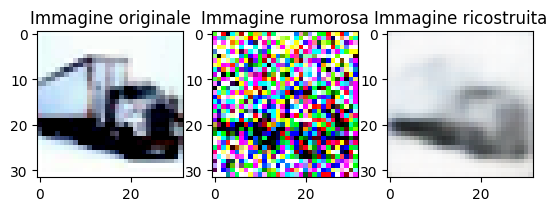

In [26]:
# Testiamo il modello sul test set
for data in dataloader:
    img, _ = data
    # img = img.view(img.size(0), -1)
    img = img.cuda()
    # forward pass
    output = model(img)
    output = output.detach().cpu()
    pic = to_img(output)
    pic_plot = torch.permute(pic[0], (1,2,0))
    plt.subplot(1,3,1)
    img_plot = torch.permute(img.cpu()[0], (1,2,0))
    plt.imshow(img_plot)
    plt.title("Immagine originale")
    plt.subplot(1,3,2)
    noise = torch.randn_like(img)
    img_plot = torch.permute(img.cpu()[0]+noise[0].cpu(), (1,2,0))
    plt.imshow(img_plot)
    plt.title("Immagine rumorosa")
    plt.subplot(1,3,3)
    plt.imshow(pic_plot)
    plt.title("Immagine ricostruita")